## タイタニック生存予測 ランダムフォレスト
### データ取得・データ読み込み（sample）
一部カラム構成が意味するところは下記の通り  
Survived　⇛　生存（０ = No, 1 = Yes）  
Pclass ⇛　チケットの等級（1 = 1st, 2 = 2nd, 3 = 3rd　※1stが上級等級）  
SibSp　⇛　タイタニックに乗船していた兄弟・姉妹・まま兄弟・まま姉妹・配偶者の数  
parch　⇛　タイタニックに乗船していた子供の数  
Fare　⇛ 乗船賃  
Embarked　⇛　搭乗した港  

In [20]:
# データ読み込み
import pandas as pd
data_train = pd.DataFrame(pd.read_csv("train.csv"))
data_test = pd.DataFrame(pd.read_csv("test.csv"))

data_train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
549,550,1,2,"Davies, Master. John Morgan Jr",male,8.0,1,1,C.A. 33112,36.7500,NaN,S
453,454,1,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C92,C
247,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
355,356,0,3,"Vanden Steen, Mr. Leo Peter",male,28.0,0,0,345783,9.5000,NaN,S
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C


### データ確認1　欠損値の有無
特徴量ごとに欠損値を確認する。Age、Cabin、Embarkedは両データに欠損値が認められる。Fareはテストデータのみ欠損。

In [21]:
data_train.isnull().any(axis=0)

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [4]:
data_test.isnull().any(axis=0)

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

### データ確認2　欠損値の数

In [5]:
data_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
data_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

###  前処理について記述せよ
#### ・前処理とは何か
データのカラム構成や様式は多様であるため、分析目的に応じた機械学習を行いやすいようデータを整えること。そのデータ内容を理解し、データフレームなどの形式に加工し、一部を分析可能なデータ型（文字⇛整数型など）に変更するなど。

#### ・なぜ前処理を行う必要があるのか
例えば欠損値があるデータを学習やテストに使った場合、それだけで結果がブレてしまう。また、文字データ（本件でいえば男女）はそのままでは統計解析に使えない。このような事態を避けるため。

#### ・前処理は具体的に何を行うか(3つ以上記述せよ)
1.　欠損値の処理  
2.　文字列データを数値に変換  
3.　データの正規化


#### ・前述した具体的な前処理について、その前処理を行うと何を得ることができるか(記述したそれぞれの前処理例について記述せよ)
###### （1）欠損値の処理 
何らかの要因によりデータに欠損がある場合、分析作業が複雑になったり結果にバイアスがかかる恐れがある。これを避けるために処理を行う。 


■欠損値の有無を特定  
欠損がどのような理由で発生しているかを推定する  
⇛ランダム（Missing Completely At Random）…タイプミス、ヒューマンエラー、原因不明  
⇛別変数に依存する欠損（Missing At Random）…1次試験の合格者のみ２次試験を受験するなど  
⇛欠損している変数そのものに依存する欠損（Missing Not At Random）…100℃以上は計測できない温度計など


■対応  
(a)MCARの場合  
⇛（削除）リストワイズ法...欠損値を持つ行を削除  
⇛（代入）平均値代入法…カラムの平均値により欠損値を補完  
⇛（代入）回帰代入法…欠損値のないサンプルに回帰分析を行い、推定値をもとに欠損値を補完  


(b)MARの場合  
単純に欠損がある行を削除したり埋めたりしてしまうと、データが歪められて適切な分析ができない恐れがある。  
⇛（代入）最尤推定法…最も尤度が高くなるように欠損値を補完  
⇛（代入）多重代入法…欠損値を代入したデータセットを複数個作成して結合


（c）MNARの場合  
データの性質に応じて、MCARやMARのときに取った手法を適宜活用する

###### （2）文字列データを数値に変換
機械学習のアルゴリズムは数値を前提にしているケースが多くそのままでは統計処理できないので、一定の規則性をもとに数値に変換する。


###### （3）正規化
数量を代表値で割るなどして無次元量化して本来次元が異なる特徴量同士を相互比較できるようにする。　　
ただし、ランダムフォレストでは学習を行う際に正規化は必要ない。
（a）二条平均平方根が1になるよう変換
（b）平均が0、標準偏差が1になるように変換　※標準正規分布　こちらを使用するのが一般的

### 2/前処理について記述せよ
###### データを確認する際に見るべきポイント
(1)データ総数  
(2)欠損の有無  
(3)文字列データの有無  
(4)各特徴量の分散

### 前処理を行う1

In [22]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.
5,6,0,3,male,Unknown,0,0,2_quartile,N,"Moran,",Mr.
6,7,0,1,male,Adult,0,0,4_quartile,E,"McCarthy,",Mr.
7,8,0,3,male,Baby,3,1,3_quartile,N,"Palsson,",Master.
8,9,1,3,female,Young Adult,0,2,2_quartile,N,"Johnson,",Mrs.
9,10,1,2,female,Teenager,1,0,3_quartile,N,"Nasser,",Mrs.


### 前処理を行う2

In [23]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


### 前処理の内容について記述せよ
各メソッドで何を行っているか、なぜそのようなことを行っているか、それを行うことでのメリットは何か。  
###### simply_ages
欠損値を一律「-0.5」で埋めたうえで、当該カラムデータを境界値(-1, 0, 5, 12, 18, 25, 35, 60, 120)で区切って各セグメントにラベルを与える処理。欠損はランダムに発生していると思われ、かつ欠損数が多いことからリストワイズ法で削除するとデータそのものを大きく減らすことになるため望ましくない。「unknown」セグメントに所属させることで、欠損処理しつつデータとしても一応活用できるようにしている。また、特徴量に含まれるユニークな数値が非常に多いため、分析結果をわかりやすくするためセグメントを区切っている。

##### simply_cabins
欠損値を一律「N」で埋めたうえで、当該カラムデータをすべてをその頭文字のみ抜き出して表示するようにする処理。欠損数が非常に多いため、リストワイズ法で削除したのでは今後のデータ分析におおきなバイアスがかかる。そこで欠損値は「N」というセグメントを与える。また、キャビンは「アルファベット」＋「整数」で構成され、前者が区画、後者が部屋番号である。部屋番号ごとに分析したのでは傾向を算出することが不可能であるため、区画単位で分析できるよう区画を表す「アルファベット」1文字のみを抜き出している。

##### simply_fares
欠損値を「0.5」で埋めたうえで、当該カラムデータを境界値(-1, 0, 8, 15, 31, 1000)で区切って各セグメントにラベルを与える処理。乗船賃もユニークな数値が非常に多いため、分析結果を明瞭とするため一定のセグメントに区切っている。

##### format_name
Nameカラムにおいて最初の半角アキまでを名前として、そこからふたつめの半角アキまでを接頭辞として抜き出し、別々のカラムとしてデータフレームに適用する。Nameカラムには、名前と接頭辞というふたつのデータが格納されてしまっている。それらを分離し、両方を特徴量として分析に活用できるようにできる。

##### drop_features
データフレームから「Ticket」「Name」「Embarked」を外す。チケット番号は生存に関する有意差にはつながりにくいと推察されるうえ、データの形式が一定ではない（整数のみ、アルファベット+整数のものが混在）ため除外。名前は名前と接頭辞にわけて格納したため、加工前のカラムを消去。搭乗した港も生存に関する有意差にはつながらないと推察されるため消去。

##### encode_features
featuresで定義した特徴量（文字列データになっているもの）をdf_trainとdf_testから抜き出してデータフレームを行方向に結合する。そして、各特徴量（'Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix'）それぞれに対して、文字列を数値に変更したうえで各データフレームにそれを反映する。文字列データはそのまま学習ができないため、数値型に変換することを目的としている。

### モデル選択について記述せよ
生存予測に使用できそうなモデルと、それぞれの概要・長所・短所。

###### 単層パーセプトロン
概要：分類対象から素性を二次元ベクトルとして抽出。それをもとにデータを二値に分類して識別する。　　
長所：入力層・出力層のみで構成されるため、毎回の学習が早く済む。  
短所：１本の直線で分類できる（線形分離可能）データ以外には適用しがたい。

###### サポートベクターマシン（SVM）
概要：訓練データから各データ点との距離が最大となるという基準でデータを二値に分類する。
長所：汎化能力に優れ、現在の二値分類手法においてはもっとも優秀な識別能力をもつ。
短所：多クラス分類にはそのまま適用できず計算量も多くなってしまう。

###### ロジスティクス回帰
概要：複数の説明変数から、二値変数を説明・予測する解析法。
長所：回帰分析のいち手法であるため、これから発生する同事象についても予測分類（確率計算）ができる。
短所：多数の説明変数から目的変数の変動を予測するまめの最適な組み合わせを模索する必要があり、その方法が複数あり複雑。

###### K近傍法
概要：学習データをベクトル空間上にプロットし、未知のデータが得られた際にそこから距離が近い順のk個から多数決でデータが属するクラスを分類する解析法。
長所：学習データの分布について特別な条件がない
短所：特徴量がどの程度影響力があるのかを判別するのが難しい

### モデル選択の基準
###### 基準1　分析結果の出力方法
分類なのか、回帰なのか、異常値検知なのか。目的によって選択肢に入るモデルが絞られる。

###### 基準2　予測精度
学習から得られたモデルが値をどれだけ正確に出力するか。過学習の問題を解消できるならば非線形性を有するモデルほど精度が高い傾向がある。モデルのパラメーター数、特徴量の数、線形性の有無などが影響を与える。

###### 基準3　中身のわかりやすさ
説明変数と目的変数の関係が明確であること。予測精度が高いほど中身がわかりにくい傾向がある。

### モデル選択におけるデータ可視化

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

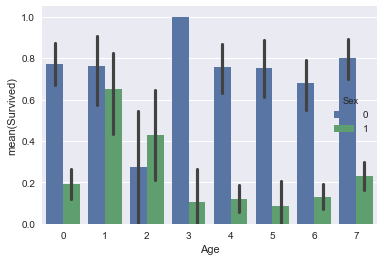

In [10]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

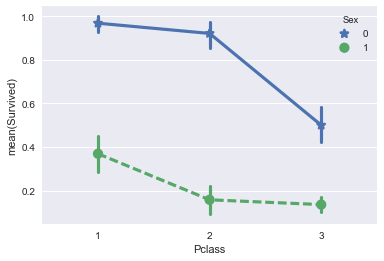

In [11]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train, markers=["*", "o"], linestyles=["-", "--"])

### データ可視化の結果について考察せよ
まず、全体的に男性の生存率が女性のそれより高い。年齢で見ると、男性は「５〜１２歳の生存率が際立って低い」「１２〜１８歳の生存率が高い」「他の年代はおおよそ横ばい」であること、女性は「０〜５歳と5〜１２歳（つまりは子供）の生存率が際立って高い」「他の年代はおおよそ横ばいで低い」ことがわかる。チケット等級で見ると、等級が高くなるほど生存率が高い。ただし、男性は１〜２等でそこまで大きな差が開かず、女性は２〜３等でそこまで大きな差が開いていない。  

連続性のあるデータではなく、「属性」によって生存率が大きく変動していることを鑑み、モデル選択の際には非線型の分類器を用いることが適切であると推察される。

### データセットの分割
###### 学習データとテストデータの比は8:2とする。

In [24]:
from sklearn.model_selection import train_test_split

X = data_train.drop(['Survived', 'PassengerId'], axis=1)
y = data_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

### ランダムフォレストについて記述せよ
決定木とは、属性とその値によって表現さてたデータをいくつかのクラスに分類する教師あり学習の手法。決定木には結果の可視化が用意であるという利点がある反面、過剰適合しやすく汎化能力は低いという欠点がある。これを補うため、複数の決定木が出した結果を多数決して結論を出す「アンサンブル学習」を主に用いることになるが、そのいち手法がランダムフォレストである。  

ランダムフォレストでは、それぞれの決定木で使う特徴量を予め決められた数だけランダムに選択する。こうすることでばらつきが出て、各決定木の結果が似てしまう（アンサンブル学習の効果が低くなる）ことを改善している。   

ランダムフォレストの長所、短所は次の通り。  
長所：データの正規化・標準化を行う必要がない、計算速度が早い、特徴量の重要度を算出することができる  
短所：重要度が高い説明変数の数が欠損などにより少ないと適切に分析できない、パラメータが多い、説明変数をランダムに抽出するため、変数が少なすぎると各決定木の結果が似通ってしまい適切な効果が得られない  

今回は説明変数が複数個あり、単純な線形モデルでは精度が出ないと推察される。また、特徴量は性別などの「属性」を表しているものが多く、連続性のあるものがない。さらに出力したい結果は「生存」「死亡」の二値分類と、そうなる要因として何が重要であったのかであるため、分類モデルでありかつ特徴量ごとの重要度を出力できるランダムフォレストが適切である。

### 学習

In [25]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=13,criterion='entropy', random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

### accuracyを求める・精度を高める

In [26]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.956460674157
0.821229050279


### ハイパーパラメーターについて
###### ハイパーパラメーターとは何か
モデルの複雑さを決めるような次数や正則化パラメーター（過学習などを防いだり精度を向上させるために追加項の導入）のこと。

###### ランダムフォレストにおいてどのようなハイパーパラメーターがあるか（4つ以上）。それらを変更するとどう作用するか、どのような設定値があるか
・n_estimators：生成する木の数、整数型で入力  
・criterion：ノード分割時の不順度の計算種別、ジニまたはエントロピー  
・max_features：特徴量抽出の最大値、整数型・少数型（%と識別）・オート・2の自然対数など  
・max_depth: 木の深さ 、整数型で入力
・min_samples_split：分割時の分割先における最小データ数、整数型もしくは少数型（%と識別）で入力  
・min_samples_leaf：終端ノードの最小データ数、整数型もしくは少数型（%と識別）で入力  
・min_weight_fraction_leaf：終端ノードの最小分割比、整数型もしくは少数型（%と識別）で入力  
・max_leaf_nodes：終端ノードの最大数、整数型で入力  
など






### チューニング
以下の観点からチューニングを複数行い、精度の向上を目指す。

n_estimators': [4, 6, 9]  
max_features': ['log2', 'sqrt','auto']  
criterion': ['entropy', 'gini']  
max_depth': [2, 3, 5, 10]  
min_samples_split': [2, 3, 5]  
min_samples_leaf': [1,5,8]

In [27]:
from sklearn.metrics import make_scorer, accuracy_score
clf = RandomForestClassifier(n_estimators=6, 
                             max_features="auto", 
                             max_depth=3,
                             criterion='gini', 
                             min_samples_split=2,
                             min_samples_leaf=5,
                             random_state=0)
clf.fit(X_train, y_train)
acc_scorer = make_scorer(accuracy_score)
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.843575418994


###### グリッドサーチを用いてパラメーターを最適化する方法

In [28]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)


predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.787709497207


### 検証について記述せよ
###### 検証とは何か
個々のモデルの汎化性能を評価すること。


###### なぜ検証を行う必要があるのか(Accuracyだけではダメな理由も含めること)
過学習によりモデルの汎化能力が落ちていないかを測定し、使用したデータセット以外にも適用できるようチューニングしなければならないため。現在のモデルの精度だけを測定しても汎化能力があるとは言い切れないため別途検証する必要がある。


###### 主な検証方法について2つ以上記述せよ
（１）学習曲線  
学習用データの際の精度と、テストの際の精度を同時にプロットすることで視覚的に判断する。  


（２）ホールドアウト法
元のデータセットを学習用データとテストデータに分割する。ただし、データの分け方により性能評価がかなり変わってしまうため、後述するk分割交差検証を用いるケースが多い。


（３）k分割交差検証（KFold）
データをK個にランダム分割。そのうち１個をテストデータ、残るK-１個を学習用データとする。分割後、実際に学習とテストを行い、これをK個それぞれのデータの組み合わせに対してK回繰り返して行う。最後に、それぞれで算出した精度を平均化して最終的な精度とする。

### KFoldについて記述せよ
データをK個にランダム分割。そのうち１個をテストデータ、残るK-１個を学習用データとする。分割後、実際に学習とテストを行い、これをK個それぞれのデータの組み合わせに対してK回繰り返して行う。最後に、それぞれで算出した精度を平均化して最終的な精度とする(上記内容ママ)。

### KFoldを実装する・結果を確認する

In [32]:
from sklearn.model_selection import KFold
import numpy as np
kf = KFold(n_splits=10)
outcomes = []
fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    outcomes.append(accuracy)
    print("Fold {0} accuracy: {1}".format(fold, accuracy))     
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome)) 

Fold 1 accuracy: 0.8111111111111111
Fold 2 accuracy: 0.8314606741573034
Fold 3 accuracy: 0.8089887640449438
Fold 4 accuracy: 0.8089887640449438
Fold 5 accuracy: 0.8314606741573034
Fold 6 accuracy: 0.8764044943820225
Fold 7 accuracy: 0.7640449438202247
Fold 8 accuracy: 0.8089887640449438
Fold 9 accuracy: 0.8202247191011236
Fold 10 accuracy: 0.7752808988764045
Mean Accuracy: 0.8136953807740325


### どの特徴量が重要であったかを調査する

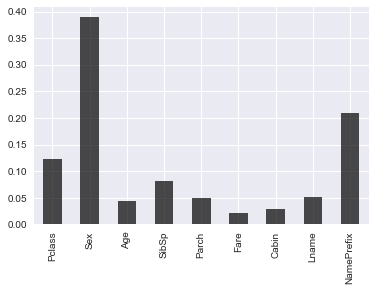

In [30]:
data = pd.Series(clf.feature_importances_, 
          index=["Pclass","Sex","Age","SibSp","Parch","Fare","Cabin","Lname","NamePrefix"])
data.plot(kind="bar", color="k", alpha=0.7)